# Machine Learning Pipeline - Data Analysis

Implementation of each of the steps in the Machine Learning Pipeline. 

1. **Data Analysis**
2. Feature Engineering
3. Feature Selection
4. Model Training
5. Obtaining Predictions / Scoring

Plane Crash Dataset available on [Kaggle.com](https://www.kaggle.com/datasets/kamilkarczmarczyk/plane-crash-dataset-03042023). See below for more details.

===================================================================================================

Data description:
- Date: Date of accident, in the format - January 01, 2001
- Time: Local time, in 24 hr. format unless otherwise specified
- Airline/Op: Airline or operator of the aircraft
- Flight #: Flight number assigned by the aircraft operator
- Route: Complete or partial route flown prior to the accident
- AC Type: Aircraft type
- Reg: ICAO registration of the aircraft
- cn / ln: Construction or serial number / Line or fuselage number
- Aboard: Total aboard (passengers / crew)
- Fatalities: Total fatalities aboard (passengers / crew)
- Ground: Total killed on the ground
- Summary: Brief description of the accident and cause if known

# Data Analysis

In [1]:
# ! python -m spacy download en_core_web_sm
# ! pip install pytest
# ! pip install ipytest
# ! pip install varname

In [113]:
# to handle datasets
import pandas as pd
import numpy as np
import datetime as dt
import re
from varname import nameof

import ipytest
ipytest.autoconfig()

from datetime import date as date_, time as time_
from pydantic import BaseModel, Field
from typing import List
import pandera as pa
from pandera.typing import DataFrame, Series
import pydantic
from typing import Optional

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

# for the yeo-johnson transformation
import scipy.stats as stats

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import spacy
from typing import Union
import logging
import itertools

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import spacy.cli
import gensim.downloader as api
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import FastText
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict

%matplotlib inline

In [3]:
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")
# nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 916.8 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [4]:
logging.getLogger().setLevel(logging.INFO)
# logging.info(f"\033[033m***TEST***: {data.shape=}\033[0m") 

In [5]:
# load dataset
raw_data = pd.read_csv("data/raw_data.csv", sep=";")

# rows and columns of the data
logging.info(f"\033[36m {raw_data.shape=}\033[0m")

# visualise the dataset
raw_data.head()

INFO:root: raw_data.shape=(5028, 17)


,Date,Time:,Location:,AC Type:,Operator:,Route:,cn / ln:,Flight #:,Is_military,Military country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground:,Registration:,Summary:
0,18.03.1946,NaN,"Between Chungking and Shanghai, China",NaN,China National Aviation Corporation,Chunking - Shanghai,NaN,NaN,No,NaN,?,?,?,?,NaN,139,Disappeared while en route. Plane never located.
1,09.11.1944,NaN,"Seljord, Norway",NaN,Military - U.S. Army Air Corps,NaN,NaN,NaN,Yes,U.S. Army Air Corps,?,?,?,?,NaN,42-52196,NaN
2,09.05.1989,NaN,"Near Tainjin, China",Bell 412,Aero Asahi,NaN,33070,NaN,No,NaN,?,?,10,?,0.0000,JA9596,NaN
3,20.02.1992,NaN,En route from Argentina to California,Boeing B-747,Aerolineas Argentinas,NaN,NaN,386,No,NaN,?,?,1,?,0.0000,NaN,A passenger died of cholera while en route.
4,13.03.1954,NaN,"Dien Bien Phu, South Vietnam",C-46,Aigle Azur,NaN,NaN,NaN,No,NaN,?,?,?,?,NaN,NaN,Shot down.


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5028 entries, 0 to 5027
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   5028 non-null   object 
 1   Time:                  3482 non-null   object 
 2   Location:              5023 non-null   object 
 3   AC        Type:        5014 non-null   object 
 4   Operator:              5018 non-null   object 
 5   Route:                 4264 non-null   object 
 6   cn / ln:               4358 non-null   object 
 7   Flight #:              1338 non-null   object 
 8   Is_military            5018 non-null   object 
 9   Military country       766 non-null    object 
 10  Aboard_all             5028 non-null   object 
 11  Aboard_passengers      5028 non-null   object 
 12  Fatalities_all         5028 non-null   object 
 13  Fatalities_passengers  5028 non-null   object 
 14  Ground:                4984 non-null   float64
 15  Regi

In [7]:
# make a copy of original data to work with
data = raw_data.copy()

In [8]:
# rename columns
multiple_white_spaces = re.compile(r"\s+")
data.columns = [multiple_white_spaces.sub("_", _) for _ in (re.sub(r"[:/]", "", c) for c in data.columns)]

logging.info(f"\033[36m {data.columns=}\033[0m")

INFO:root: data.columns=Index(['Date', 'Time', 'Location', 'AC_Type', 'Operator', 'Route', 'cn_ln',
       'Flight_#', 'Is_military', 'Military_country', 'Aboard_all',
       'Aboard_passengers', 'Fatalities_all', 'Fatalities_passengers',
       'Ground', 'Registration', 'Summary'],
      dtype='object')


# Data schemas

In [9]:
class DataSchemaValidation(BaseModel):
    date: date_ = Field(alias="Date")
    time: time_ = Field(alias="Time")
    location: str = Field(alias="Location")
    ac_type: str = Field(alias="AC_Type")
    operator: str = Field(alias="Operator")
    route: str = Field(alias="Route")
    cn_ln: str = Field(alias="cn_ln")
    flight_n: str = Field(alias="Flight_#")
    is_military: str = Field(alias="Is_military")
    mlitary_country: str = Field(alias="Military_country")
    aboard_all: int = Field(alias="Aboard_all")
    aboard_passengers: int = Field(alias="Aboard_passengers")
    fatalities_all: int = Field(alias="Fatalities_all")
    fatalities_passengers: int = Field(alias="Fatalities_passengers")
    ground: int = Field(alias="Ground")
    registration: str = Field(alias="Registration")
    summary: str = Field(alias="Summary")
    year: Optional[int] = Field(alias="Year")
    decade: Optional[int] = Field(alias="Decade")
    month: Optional[int] = Field(alias="Month")
    hour: Optional[int] = Field(alias="Hour")
    routes_n: Optional[int] = Field(alias="Routes_#")
    vector: Optional[list] = Field(alias="Vector")
    fatalities: Optional[int] = Field(alias="Fatalities")
    survived: Optional[int] = Field(alias="Survived")
    survived_pct: Optional[float] = Field(alias="Survived_pct")


class DataSchema:
    date = "Date"
    time = "Time"
    location = "Location"
    ac_type = "AC_Type"
    operator = "Operator"
    route = "Route"
    cn_ln = "cn_ln"
    flight_n = "Flight_#"
    is_military = "Is_military"
    mlitary_country = "Military_country"
    aboard_all = "Aboard_all"
    aboard_passengers = "Aboard_passengers"
    fatalities_all = "Fatalities_all"
    fatalities_passengers = "Fatalities_passengers"
    ground = "Ground"
    registration = "Registration"
    summary = "Summary"
    routes_lst = "Routes_lst"
    year = "Year"
    decade = "Decade"
    month = "Month"
    hour = "Hour"
    routes_n = "Routes_#"
    vector = "Vector"
    fatalities = "Fatalities"
    survived = "Survived"
    survived_pct = "Survived_pct"

## Missing values/ Unique values

In [10]:
# list of columns to drop after EDA
redundant_columns = []

# replace missing values in form of "?"
data = data.replace("?", np.nan)

In [11]:
def get_pct_missing_and_unique(col: str) -> None:
    logging.info(f"\033[33m{col}\033[0m field has \033[36m{data[col].isna().sum()/data.shape[0]:.2%}\033[0m missing values")
    logging.info(f"\033[33m{col}\033[0m field has \033[32m{data[col].nunique()/data.shape[0]:.2%}\033[0m unique values\n")

In [12]:
for col in data.columns:
    get_pct_missing_and_unique(col)

INFO:root:Date field has 0.00% missing values
INFO:root:Date field has 91.41% unique values

INFO:root:Time field has 30.75% missing values
INFO:root:Time field has 21.16% unique values

INFO:root:Location field has 0.10% missing values
INFO:root:Location field has 82.30% unique values

INFO:root:AC_Type field has 0.28% missing values
INFO:root:AC_Type field has 48.19% unique values

INFO:root:Operator field has 0.20% missing values
INFO:root:Operator field has 45.07% unique values

INFO:root:Route field has 15.19% missing values
INFO:root:Route field has 76.55% unique values

INFO:root:cn_ln field has 13.33% missing values
INFO:root:cn_ln field has 78.02% unique values

INFO:root:Flight_# field has 73.39% missing values
INFO:root:Flight_# field has 17.96% unique values

INFO:root:Is_military field has 0.20% missing values
INFO:root:Is_military field has 0.04% unique values

INFO:root:Military_country field has 84.77% missing values
INFO:root:Military_country field has 4.26% unique val

In [13]:
# plot columns in discending order of percent unique for columns with more then 1 unique values
def plot_pct_unique(data: DataFrame) -> None:
    df = data.copy()
    # make a list of the variables that contain unique values
    vars_with_unique = [var for var in df.columns if df[var].nunique()/data.shape[0] > 0]

    # determine percentage of unique values (expressed as decimals)
    # and display the result ordered by % of unique data
    table = df[vars_with_unique].nunique().sort_values(ascending=False)/df.shape[0]
    print(table)
    
    # plot
    table.plot.bar(figsize=(10, 4))
    plt.ylabel('Percentage of unique data')
    plt.axhline(y=0.80, color='r', linestyle='-')
    plt.axhline(y=0.15, color='g', linestyle='-')

    plt.show()


# plot columns with missing values in discending order of percent missing
def plot_pct_missing(data: DataFrame) -> None:
    df = data.copy()
    # make a list of the variables that contain missing values
    vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]

    # determine percentage of missing values (expressed as decimals)
    # and display the result ordered by % of missin data
    print(df[vars_with_na].isnull().mean().sort_values(ascending=False))
    
    # plot
    df[vars_with_na].isnull().mean().sort_values(
        ascending=False).plot.bar(figsize=(10, 4))
    plt.ylabel('Percentage of missing data')
    plt.axhline(y=0.80, color='r', linestyle='-')
    plt.axhline(y=0.15, color='g', linestyle='-')

    plt.show()

Military_country        0.8477
Flight_#                0.7339
Time                    0.3075
Route                   0.1519
cn_ln                   0.1333
Registration            0.0547
Fatalities_passengers   0.0467
Aboard_passengers       0.0440
Summary                 0.0117
Ground                  0.0088
Aboard_all              0.0034
AC_Type                 0.0028
Operator                0.0020
Is_military             0.0020
Fatalities_all          0.0016
Location                0.0010
dtype: float64


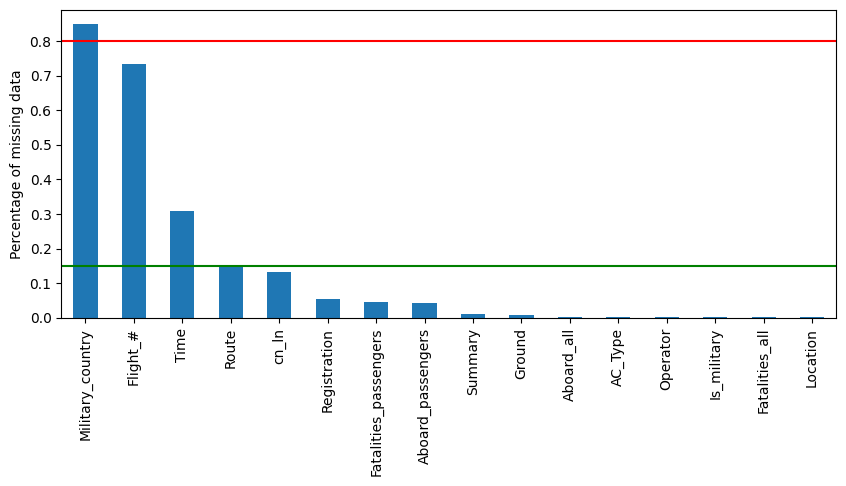

In [14]:
plot_pct_missing(data)

Summary                 0.9696
Registration            0.9381
Date                    0.9141
Location                0.8230
cn_ln                   0.7802
Route                   0.7655
AC_Type                 0.4819
Operator                0.4507
Time                    0.2116
Flight_#                0.1796
Aboard_all              0.0485
Aboard_passengers       0.0465
Military_country        0.0426
Fatalities_all          0.0396
Fatalities_passengers   0.0378
Ground                  0.0099
Is_military             0.0004
dtype: float64


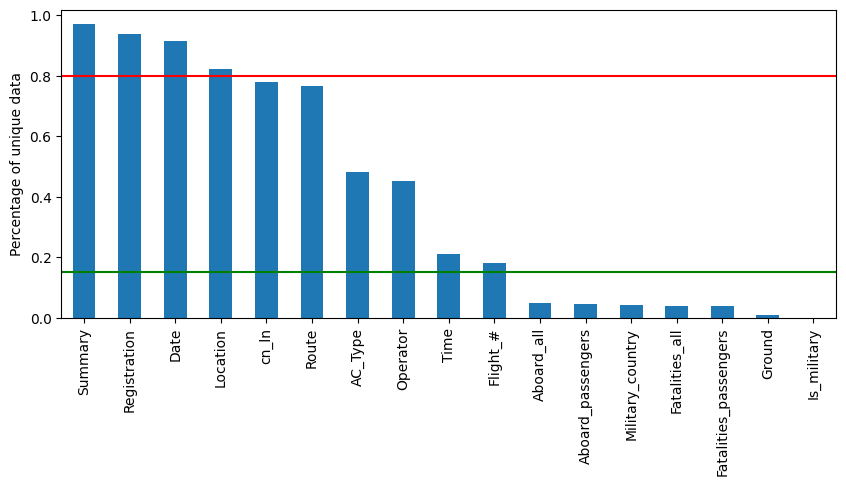

In [15]:
plot_pct_unique(data)

In [16]:
redundant_columns.extend([DataSchema.mlitary_country, DataSchema.flight_n, DataSchema.time])

# Drop samples that has missing values in columns

In [17]:
test = data.copy()
vars_with_na = [var for var in data.columns if data[var].isnull().sum()/data.shape[0] < 0.15]
test.dropna(subset=vars_with_na, inplace=True)
logging.info(f"\033[36m{raw_data.shape=}\n{' '*10}{test.shape=}\033[0m")
logging.info(f"test dataset reduced by \033[35m{1-test.shape[0]/raw_data.shape[0]:.2%}\033[0m\
 dropping samples w/ nan in columns w/ \033[35mmssings values under 15%\033[0m")
test = data.copy()
vars_with_na = [var for var in data.columns if data[var].isnull().sum()/data.shape[0] < 0.05]
test.dropna(subset=vars_with_na, inplace=True)
logging.info(f"\033[36m{raw_data.shape=}\n{' '*10}{test.shape=}\033[0m")
logging.info(f"test dataset reduced by \033[35m{1-test.shape[0]/raw_data.shape[0]:.2%}\033[0m\
 dropping samples w/ nan in columns w/ \033[35mmssings values under 5%\033[0m")

data.dropna(subset=[DataSchema.summary], inplace=True)
logging.info(f"\033[36m{raw_data.shape=}\n{' '*10}{data.shape=}\033[0m")
logging.info(f"dataset reduced by \033[32m{1-data.shape[0]/raw_data.shape[0]:.2%}\033[0m\
 dropping samples with missing \033[32msummary\033[0m")

INFO:root:raw_data.shape=(5028, 17)
          test.shape=(4222, 17)
INFO:root:test dataset reduced by 16.03% dropping samples w/ nan in columns w/ mssings values under 15%
INFO:root:raw_data.shape=(5028, 17)
          test.shape=(4723, 17)
INFO:root:test dataset reduced by 6.07% dropping samples w/ nan in columns w/ mssings values under 5%
INFO:root:raw_data.shape=(5028, 17)
          data.shape=(4969, 17)
INFO:root:dataset reduced by 1.17% dropping samples with missing summary


# Route

In [18]:
get_pct_missing_and_unique(DataSchema.route)

INFO:root:Route field has 14.41% missing values
INFO:root:Route field has 77.26% unique values



In [19]:
data[DataSchema.route].sample(5)

2916    Lajes, Azores - Bermuda
175                 Bombing run
4834           Dezful - Mashhad
3239                        NaN
1098            Madang - Goroka
Name: Route, dtype: object

In [20]:
# get number of routes(airports)
def get_multiple_locations(text: str) -> Union[None, str]:    
    if text is np.nan:
        return text
    route = text.split(" - ")    
    for point in route:
        doc = nlp(point)
        for ent in doc.ents:
            if ent.label_=="GPE":
                point = ent.text
    flatten = list(itertools.chain(*[[j] if isinstance(j, str) else j for j in [i.split(", ") for i in route]]))
    return flatten

In [21]:
%%ipytest -qq

# TEST

input_output = [
    ("Sukhumi - Kutaisi", ["Sukhumi", "Kutaisi"]), 
    ("Test flight", ["Test flight"]),
    (np.nan, np.nan), 
    ("Bombing run", ["Bombing run"]), 
    ("Kaboul-Kunduz", ["Kaboul", "Kunduz"]),
    ("Burbank,- St. Paul", ["Burbank", "St. Paul"]),
    ("Boston - NY - Washington DC - Jacksonville - Miami", ["Boston", "NY", "Washington DC", "Jacksonville", "Miami"]),
    ("Lima - Pucallpa - Iquitos", ["Lima", "Pucallpa", "Iquitos"])
]


@pytest.mark.nondestructive
@pytest.mark.parametrize("item,expected",input_output)
def test_get_multiple_locations(item, expected):
    output = get_multiple_locations(item)
    assert output in [expected], f"Expected output is {expected}, got: {output}"

....FF..                                                                                     [100%]
============================================= FAILURES =============================================
_______________________ test_get_multiple_locations[Kaboul-Kunduz-expected4] _______________________

item = 'Kaboul-Kunduz', expected = ['Kaboul', 'Kunduz']

    @pytest.mark.nondestructive
    @pytest.mark.parametrize("item,expected",input_output)
    def test_get_multiple_locations(item, expected):
        output = get_multiple_locations(item)
>       assert output in [expected], f"Expected output is {expected}, got: {output}"
E       AssertionError: Expected output is ['Kaboul', 'Kunduz'], got: ['Kaboul-Kunduz']
E       assert ['Kaboul-Kunduz'] in [['Kaboul', 'Kunduz']]

/var/folders/24/kzw5nvd15h3_0w6x7c40l6t00000gq/T/ipykernel_90193/420097867.py:19: AssertionError
____________________ test_get_multiple_locations[Burbank,- St. Paul-expected5] _____________________

item = 'Burbank,- 

In [22]:
# replace Route free text value with list of destinations per flight
data[DataSchema.routes_lst] = data[DataSchema.route].apply(lambda x: get_multiple_locations(x))

In [23]:
# create new column derived from Route and represented number of routes per flight
data[DataSchema.routes_n] = data[DataSchema.routes_lst].apply(lambda x: 0 if x is np.nan else len(x))

In [24]:
data[DataSchema.routes_n].value_counts()

Routes_#
2    2905
0     716
4     452
3     441
1     369
5      59
6      26
7       1
Name: count, dtype: int64

In [25]:
data[data[DataSchema.routes_n] == 0].sample(5)

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary,Routes_lst,Routes_#
3388,28.10.1970,NaN,"Pointe-à-Pitre, Guadeloupe",Curtiss C-46D,Aerocosta Colombia,NaN,33060,NaN,No,NaN,4,1,2,0,0.0000,HK-792,The cargo plane crashed while attempting to ma...,NaN,0
2888,24.12.1935,NaN,"Wroctaw, Poland",Heinkel He-70,Deutsche Lufthansa,NaN,915,NaN,No,NaN,3,2,3,2,0.0000,D-UVOR,Crashed under unknown circumstances,NaN,0
8,13.06.1956,NaN,Over North Carolina,Douglas DC-3,Piedmont,NaN,NaN,NaN,No,NaN,NaN,NaN,1,1,0.0000,NaN,A passenger fell to his death after the door o...,NaN,0
3905,29.06.1929,21:00:00,"Near Lindau, Bavaria, Germany",Domier Delphin III (flying boat),Bodensee Aerolloyd,NaN,151,NaN,No,NaN,5,4,5,4,0.0000,D-1620,The seaplane crashed into lake Constance while...,NaN,0
1640,30.05.1932,12:00:00,"Portland, Oregon",Boeing 40,Varney Air Lines,NaN,1155,NaN,No,NaN,2,0,1,0,0.0000,NC830M,Crashed in a river after the engine exploded.,NaN,0


In [26]:
def get_number_of_routes(routes_n: int) -> int:
    if routes_n == 0:
        return "Missing"
    elif routes_n == 2:
        return "Two"
    else:
        return "Rare"
    
data[DataSchema.routes_n] = data[DataSchema.routes_n].copy().apply(lambda x: get_number_of_routes(x))

In [27]:
redundant_columns.append(DataSchema.route)

## Date: extract year and month

In [29]:
get_pct_missing_and_unique(DataSchema.date)

INFO:root:Date field has 0.00% missing values
INFO:root:Date field has 91.47% unique values



In [30]:
# extract year and month from date into separate columns
data[DataSchema.year] = pd.to_datetime(data[DataSchema.date]).dt.year
data[DataSchema.decade] = data[DataSchema.year].apply(lambda x: x-(x%10))
data[DataSchema.month] = pd.to_datetime(data[DataSchema.date]).dt.month
redundant_columns.append(DataSchema.date)

In [31]:
for col in [DataSchema.year, DataSchema.month]:
    get_pct_missing_and_unique(col)

INFO:root:Year field has 0.00% missing values
INFO:root:Year field has 2.27% unique values

INFO:root:Month field has 0.00% missing values
INFO:root:Month field has 0.24% unique values



## Location: extract state

In [32]:
get_pct_missing_and_unique(DataSchema.location)

INFO:root:Location field has 0.10% missing values
INFO:root:Location field has 82.29% unique values



In [33]:
data[DataSchema.location].sample(5)

355                     Alma-Ata, Kazakhstan
910                   Villa Pinzon, Colombia
1378    En route Miami, FL - Nassau, Bahamas
4598                Phan Rang, South Vietnam
1965                         Irkutsk, Russia
Name: Location, dtype: object

In [34]:
def get_locations(text: str) -> Union[None, str]:    
    if text is np.nan:
        return text
    locations = [] 
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_=="GPE":
            locations.append(ent.text)
    return locations[-1] if locations else text

In [35]:
%%ipytest -qq

# TEST

input_output = [("Between Chungking and Shanghai, China", "China")]


@pytest.mark.nondestructive
@pytest.mark.parametrize("item,expected",input_output)
def test_get_locations(item, expected):
    output = get_locations(item)
    assert output in [expected], f"Expected output is {expected}, got: {output}"

.                                                                                            [100%]
========================================= warnings summary =========================================
../../../.pyenv/versions/3.11.0/envs/deploing_ml_models/lib/python3.11/site-packages/_pytest/config/__init__.py:1204
  /Users/Viktoryia.Kisialeuskaya/.pyenv/versions/3.11.0/envs/deploing_ml_models/lib/python3.11/site-packages/_pytest/config/__init__.py:1204: PytestAssertRewriteWarning: Module already imported so cannot be rewritten: typeguard
    self._mark_plugins_for_rewrite(hook)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html


In [36]:
data[DataSchema.location] = data[DataSchema.location].apply(lambda x: get_locations(x))
data[DataSchema.location]

0                              China
3                         California
4       Dien Bien Phu, South Vietnam
6                              China
8                     North Carolina
                    ...             
5023                    Saudi Arabia
5024                        Oklahoma
5025                      Kazakhstan
5026                        Pakistan
5027                         Ireland
Name: Location, Length: 4969, dtype: object

In [37]:
print(f"Location field after parsing for country has \033[31m{data[DataSchema.location].nunique()/data.shape[0]:.2%}\033[0m unique values")

Location field after parsing for country has 10.06% unique values


## AC Type: check for missing values

In [38]:
get_pct_missing_and_unique(DataSchema.ac_type)

INFO:root:AC_Type field has 0.22% missing values
INFO:root:AC_Type field has 48.38% unique values



In [39]:
data[DataSchema.ac_type]

0                                      NaN
3                             Boeing B-747
4                                     C-46
6                             Douglas C-47
8                             Douglas DC-3
                       ...                
5023                       Lockheed C-130H
5024                 Lockheed 188C Electra
5025                            Fokker 100
5026                       Airbus A320-214
5027    Lockheed 1049H Super Constellation
Name: AC_Type, Length: 4969, dtype: object

In [40]:
data[data[DataSchema.ac_type].isna()]

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary,Routes_lst,Routes_#,Year,Decade,Month
0,18.03.1946,NaN,China,NaN,China National Aviation Corporation,Chunking - Shanghai,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,139,Disappeared while en route. Plane never located.,"[Chunking, Shanghai]",Two,1946,1940,3
22,08.11.1943,NaN,India,NaN,Military - Indian Air Force,NaN,NaN,NaN,Yes,Indian Air Force,1,NaN,1,NaN,37.0000,NaN,Crashed into a village.,NaN,Missing,1943,1940,11
1284,08.04.1922,NaN,China,NaN,NaN,Test,NaN,NaN,NaN,NaN,17,0,17,0,0.0000,NaN,Aboard were all workers taking part in a fligh...,[Test],Rare,1922,1920,4
1616,29.06.1945,NaN,India,NaN,Military - Royal Indian Air Force,NaN,NaN,NaN,Yes,Royal Indian Air Force,2,NaN,2,NaN,36.0000,NaN,Crashed into a village exploding and destoying...,NaN,Missing,1945,1940,6
1623,08.08.1951,21:00:00,Australia,NaN,Trans Australia Airlines,Hobart Melbourne,13083,NaN,No,NaN,2,0,2,0,0.0000,VH-TAT,Cargo plane. Loss of lateral control during a ...,[Hobart Melbourne],Rare,1951,1950,8
1862,17.03.1946,NaN,China,NaN,Military - Chinese Air Force,Shanghai - Nanking,NaN,NaN,Yes,Chinese Air Force,20,NaN,20,NaN,0.0000,NaN,Crashed into mountainous terrain in low visibi...,"[Shanghai, Nanking]",Two,1946,1940,3
1863,11.02.1996,NaN,Afghanistan,NaN,Military - Taliban Militia,NaN,NaN,NaN,Yes,Taliban Militia,20,NaN,20,NaN,0.0000,NaN,The helicopter was shot down.,NaN,Missing,1996,1990,2
2625,22.11.1961,NaN,Zimbabwe,NaN,Rhodesian Air Services,Salisbury - Livingstone - Elizabethville,19351,NaN,No,NaN,3,0,3,0,0.0000,VP-YRX,The aircraft was on a charter flight to Living...,"[Salisbury, Livingstone, Elizabethville]",Rare,1961,1960,11
3451,15.07.1967,NaN,Canada,NaN,Eastern Provincial Airways,NaN,NaN,NaN,No,NaN,4,3,4,3,0.0000,NaN,Crashed minutes after takeoff.,NaN,Missing,1967,1960,7
4551,26.03.1952,NaN,Russia,NaN,Aeroflot,NaN,NaN,NaN,No,NaN,70,NaN,70,NaN,0.0000,NaN,The plane overshot the runway and collided wit...,NaN,Missing,1952,1950,3


In [41]:
# TODO group Aircraft types

## ~~Operator~~

In [42]:
get_pct_missing_and_unique(DataSchema.operator)

INFO:root:Operator field has 0.18% missing values
INFO:root:Operator field has 45.26% unique values



In [43]:
data[DataSchema.operator]

0       China National Aviation Corporation
3                     Aerolineas Argentinas
4                                Aigle Azur
6       China National Aviation Corporation
8                                  Piedmont
                       ...                 
5023       Military - Royal Saudi Air Force
5024                American Flyers Airline
5025                                Bek Air
5026         Pakistan International Airline
5027               KLM Royal Dutch Airlines
Name: Operator, Length: 4969, dtype: object

In [44]:
data[data[DataSchema.operator].isna()]

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary,Routes_lst,Routes_#,Year,Decade,Month
158,07.09.1909,NaN,France,Wright Byplane,NaN,Air show,NaN,NaN,NaN,NaN,1,0,1,0,0.0000,SC1,Eugene Lefebvre was the first pilot to ever be...,[Air show],Rare,1909,1900,9
728,04.07.1943,23:00:00,Gibraltar,Consolidated Liberator B24 C,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,12,NaN,0.0000,A-L-523,"The flight, bound for London, crashed into the...",NaN,Missing,1943,1940,7
1145,17.06.1917,NaN,England,Zepplin L-48 (air ship),NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,14,NaN,0.0000,L-48,Shot down by aircraft.,NaN,Missing,1917,1910,6
1189,02.09.1963,NaN,Northeast Laos,Curtiss C-46 Commando,NaN,NaN,NaN,NaN,NaN,NaN,16,13,15,12,NaN,NaN,Refugee flight.,NaN,Missing,1963,1960,9
1284,08.04.1922,NaN,China,NaN,NaN,Test,NaN,NaN,NaN,NaN,17,0,17,0,0.0000,NaN,Aboard were all workers taking part in a fligh...,[Test],Rare,1922,1920,4
2847,26.12.2011,05:54:00,Florida,Bell 206B,NaN,"Jacksonville, FL - Gainsville, FL",2636,NaN,NaN,NaN,3,2,3,2,0.0000,N5016M,The on-demand air taxi was on a flight to proc...,"[Jacksonville, FL, Gainsville, FL]",Rare,2011,2010,12
2892,04.07.1922,NaN,Germany,LVG C VI,NaN,Hamburg - Berlin,NaN,NaN,NaN,NaN,3,2,2,1,0.0000,NaN,The passenger/mail plane lost it's engine whil...,"[Hamburg, Berlin]",Two,1922,1920,7
3932,26.09.1926,NaN,New York,Sikorsky S-25,NaN,New York - Paris,NaN,NaN,NaN,NaN,5,4,2,2,0.0000,NaN,Too much weight caused the landing gear to col...,"[New York, Paris]",Two,1926,1920,9
4847,29.05.1935,NaN,Honduras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,6,NaN,0.0000,NaN,Crashed into the Ulua River.,NaN,Missing,1935,1930,5


In [45]:
def get_operators(text: str) -> Union[None, list]:
    if text is np.nan:
        return text
    if "test" in text.lower():
        return text
    operators = []
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "ORG":
            operators.append(ent.text)
    return operators[-1] if operators else text

In [46]:
%%ipytest -qq

# TEST

input_output = [
    (np.nan, np.nan),
    ("Military - U.S. Army Air Corps", "U.S. Army Air Corps"),
    ("Test", "Test"),
    ("American Flyers Airline", "American Flyers Airline"),
    ("KLM Royal Dutch Airlines", "KLM Royal Dutch Airlines"),
    ("Air Canada", "Air Canada")
]


@pytest.mark.nondestructive
@pytest.mark.parametrize("item,expected",input_output)
def test_get_operators(item, expected):
    output = get_operators(item)
    assert output in [expected], f"Expected output is {expected}, got: {output}"

.F....                                                                                       [100%]
============================================= FAILURES =============================================
______________ test_get_operators[Military - U.S. Army Air Corps-U.S. Army Air Corps] ______________

item = 'Military - U.S. Army Air Corps', expected = 'U.S. Army Air Corps'

    @pytest.mark.nondestructive
    @pytest.mark.parametrize("item,expected",input_output)
    def test_get_operators(item, expected):
        output = get_operators(item)
>       assert output in [expected], f"Expected output is {expected}, got: {output}"
E       AssertionError: Expected output is U.S. Army Air Corps, got: Military - U.S. Army Air Corps
E       assert 'Military - U.S. Army Air Corps' in ['U.S. Army Air Corps']

/var/folders/24/kzw5nvd15h3_0w6x7c40l6t00000gq/T/ipykernel_90193/1874726575.py:17: AssertionError
========================================= warnings summary ================================

In [47]:
tmp = data.copy()
tmp["tmp"] = tmp[DataSchema.operator].apply(lambda x: get_operators(x))

In [48]:
tmp[tmp[DataSchema.operator]!=tmp["tmp"]].sample(5)

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary,Routes_lst,Routes_#,Year,Decade,Month,tmp
359,31.08.1999,20:55:00,Argentina,Boeing B-737-204C,"LAPA, Lineas Aereas Privadas Argentinas",Buenos Aires - Cordoba,20389/251,3142,No,NaN,103,98,63,60,2.0000,LV-WRZ,While attempting to take off from Jorge Newber...,"[Buenos Aires, Cordoba]",Two,1999,1990,8,Lineas Aereas
2902,11.11.1926,08:00:00,Morocco,Breguet 14,Grands Express Aeriens,Casablanca -Dakar,198,NaN,No,NaN,3,3,3,3,0.0000,F-AFAX,"While en route and cruising along the shore, t...",[Casablanca -Dakar],Rare,1926,1920,11,Grands Express
3533,02.10.1970,12:00:00,Colorado,Martin 404,"Charter, Golden Eagle Aviation Inc.","Wichita - Denver - Logan, Utah",14151,108,No,NaN,40,37,32,30,0.0000,N464M,Two charter planes took off Wichita for a flig...,"[Wichita, Denver, Logan, Utah]",Rare,1970,1970,10,Golden Eagle Aviation Inc.
1831,01.08.1977,12:36:00,California,Bell 206B JetRanger,Private KNBC Los Angeles,Burbank - Santa Barbara,NaN,NaN,No,NaN,2,1,2,1,0.0000,N4TV,"The helicopter, piloted by Francis Gary Powers...","[Burbank, Santa Barbara]",Two,1977,1970,8,Private KNBC
4573,24.08.1965,10:10:00,Hong Kong,Lockheed KC-130F,Military - U.S. Marine Corps,Hong Kong - Da Nang,3693,NaN,Yes,U.S. Marine Corps,72,66,59,57,0.0000,149802,The plane crashed into Kowloon Bay after takin...,"[Hong Kong, Da Nang]",Two,1965,1960,8,Marine Corps


In [49]:
print(f"Operator field after organisation extraction has \033[35m{tmp['tmp'].nunique()/data.shape[0]:.2%}\033[0m unique values")

Operator field after organisation extraction has 44.25% unique values


In [50]:
redundant_columns.append(DataSchema.operator)

## ~~Construction or serial number / Line or fuselage number~~

In [51]:
get_pct_missing_and_unique(DataSchema.cn_ln)

INFO:root:cn_ln field has 12.80% missing values
INFO:root:cn_ln field has 78.57% unique values



In [52]:
data[data[DataSchema.cn_ln].notna()][DataSchema.cn_ln].sample(5)

630       4-AT-49
2922     57302009
4944         1152
3903         1100
3086    181992903
Name: cn_ln, dtype: object

In [53]:
redundant_columns.append(DataSchema.cn_ln)

## ~~Flight number~~

In [54]:
get_pct_missing_and_unique(DataSchema.flight_n)

INFO:root:Flight_# field has 73.07% missing values
INFO:root:Flight_# field has 18.17% unique values



In [55]:
data[data[DataSchema.flight_n].notna()][DataSchema.flight_n].sample(5)

4822       3
2860     601
3061    3597
3652     108
3157     711
Name: Flight_#, dtype: object

## ~~Is Military~~

In [56]:
get_pct_missing_and_unique(DataSchema.is_military)

INFO:root:Is_military field has 0.18% missing values
INFO:root:Is_military field has 0.04% unique values



In [57]:
data[DataSchema.is_military].value_counts(normalize=True)

Is_military
No    0.8486
Yes   0.1514
Name: proportion, dtype: float64

In [58]:
# TODO consider to drop military samples
redundant_columns.append(DataSchema.is_military)

## ~~Military country~~

In [59]:
get_pct_missing_and_unique(DataSchema.mlitary_country)

INFO:root:Military_country field has 84.89% missing values
INFO:root:Military_country field has 4.25% unique values



## Aboard All

In [60]:
get_pct_missing_and_unique(DataSchema.aboard_all)

INFO:root:Aboard_all field has 0.18% missing values
INFO:root:Aboard_all field has 4.91% unique values



In [61]:
data.dropna(subset=[DataSchema.aboard_all], inplace=True)

## Abroad Passengers

In [62]:
get_pct_missing_and_unique(DataSchema.aboard_passengers)

INFO:root:Aboard_passengers field has 3.61% missing values
INFO:root:Aboard_passengers field has 4.72% unique values



In [63]:
data[data[DataSchema.aboard_passengers].isna()]

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary,Routes_lst,Routes_#,Year,Decade,Month
22,08.11.1943,NaN,India,NaN,Military - Indian Air Force,NaN,NaN,NaN,Yes,Indian Air Force,1,NaN,1,NaN,37.0000,NaN,Crashed into a village.,NaN,Missing,1943,1940,11
23,20.06.1940,NaN,France,Dewoitine D-338,Air France,NaN,22,NaN,No,NaN,1,NaN,1,NaN,0.0000,F-ARTD,Inadvertently shot down by French anti-aircraf...,NaN,Missing,1940,1940,6
161,28.05.1982,NaN,Indonesia,Aerospatiale 330G Puma,Pelita Air Service,NaN,1258,NaN,No,NaN,10,NaN,10,NaN,0.0000,PK-PDU,The helicopter crashed into the sea.,NaN,Missing,1982,1980,5
162,02.02.1949,16:00:00,Newfoundland,Avro Anson,Saint Lawrence Airways,Trinity - Rimouski,3708,NaN,No,NaN,10,NaN,6,NaN,0.0000,CF-FEO,Crashed shortly after taking off.,"[Trinity, Rimouski]",Two,1949,1940,2
163,01.09.1941,NaN,Scotland,Consolidated 32-2 Liberator I,British Overseas Airways,NaN,NaN,NaN,No,NaN,10,NaN,10,NaN,0.0000,AM-915,Crashed into a hillside.,NaN,Missing,1941,1940,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,02.09.1983,NaN,Canada,Britten-Norman BN-2A-21 Islander,Central Mountain Air Services,Campbell River - Smithers,0274,NaN,No,NaN,9,NaN,9,NaN,0.0000,C-GIPF,Crashed en route. NY industrialist Georgel Cog...,"[Campbell River, Smithers]",Two,1983,1980,9
4850,03.04.1939,NaN,Morocco,Caudron C.635 Simoun,Air France,NaN,7372,NaN,No,NaN,9,NaN,9,NaN,0.0000,F-AOOT,Crashed into a mountain.,NaN,Missing,1939,1930,4
4851,15.10.1981,NaN,Austria,Cessna 404 Titan,Oefag Flugdienst,Salzbourg-Olbia,404-0680,NaN,No,NaN,9,NaN,9,NaN,0.0000,OE-FCT,Crashed into a mountain.,[Salzbourg-Olbia],Rare,1981,1980,10
4852,18.04.1960,NaN,Newfoundland,Douglas C-124C Globemaster,Military - U.S. Air Force,Dover-Stephenville - Lajes - Mildenhall,43971,NaN,Yes,U.S. Air Force,9,NaN,9,NaN,0.0000,52-1062,Failed to gain altitude on take off and struck...,"[Dover-Stephenville, Lajes, Mildenhall]",Rare,1960,1960,4


In [64]:
data[DataSchema.aboard_passengers].fillna(-1, inplace = True)

## Fatalities All

In [65]:
get_pct_missing_and_unique(DataSchema.fatalities_all)

INFO:root:Fatalities_all field has 0.00% missing values
INFO:root:Fatalities_all field has 4.01% unique values



In [66]:
data.dropna(subset=[DataSchema.fatalities_all], inplace=True)

## Fatalities Passengers

In [67]:
get_pct_missing_and_unique(DataSchema.fatalities_passengers)

INFO:root:Fatalities_passengers field has 3.93% missing values
INFO:root:Fatalities_passengers field has 3.83% unique values



In [68]:
data[DataSchema.fatalities_passengers].fillna(-1, inplace = True)

## Ground

In [69]:
get_pct_missing_and_unique(DataSchema.ground)

INFO:root:Ground field has 0.65% missing values
INFO:root:Ground field has 1.01% unique values



In [70]:
# replace np.nan with mean which is 0 and change type to int
data[DataSchema.ground].fillna(0, inplace = True)
data[DataSchema.ground] = data[DataSchema.ground].astype(int)

In [71]:
data[DataSchema.ground].value_counts()

Ground
0       4710
1         62
2         36
3         21
4         16
5         12
7         10
8          9
6          6
14         5
10         5
11         4
12         4
19         4
44         4
13         4
22         4
24         3
20         3
37         2
30         2
125        2
15         2
35         2
2750       2
25         2
225        1
58         1
39         1
16         1
49         1
23         1
78         1
71         1
53         1
63         1
18         1
113        1
31         1
85         1
36         1
87         1
40         1
33         1
45         1
32         1
29         1
50         1
17         1
9          1
Name: count, dtype: int64

## ~~Registration~~

In [72]:
get_pct_missing_and_unique(DataSchema.registration)

INFO:root:Registration field has 5.06% missing values
INFO:root:Registration field has 94.25% unique values



In [73]:
data[DataSchema.registration].sample(5)

1832    F-AEGN
20         NaN
4545    N155GC
2446    C-GMXQ
1930    D-AAIG
Name: Registration, dtype: object

In [74]:
redundant_columns.append(DataSchema.registration)

# Target

In [75]:
fatalities = [
    DataSchema.aboard_all, DataSchema.aboard_passengers, 
    DataSchema.fatalities_all, DataSchema.fatalities_passengers, DataSchema.ground]
data[fatalities].sample(10)

,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground
1495,18,16,18,16,0
224,10,6,10,6,0
2433,26,23,24,21,0
4830,87,81,0,0,0
2917,30,21,30,21,0
3895,5,4,5,4,0
2812,3,1,3,1,0
1130,155,150,0,0,0
4789,82,77,82,77,0
557,116,110,0,0,0


In [76]:
# make all fatalities columns int
for col in fatalities:
    data[col] = data[col].astype(int)

In [77]:
# show only rows where any of the fatalities columns is negative
tmp = data[data[fatalities].lt(0).any(axis=1)][fatalities]
tmp

,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground
22,1,-1,1,-1,37
23,1,-1,1,-1,0
161,10,-1,10,-1,0
162,10,-1,6,-1,0
163,10,-1,10,-1,0
...,...,...,...,...,...
4850,9,-1,9,-1,0
4851,9,-1,9,-1,0
4852,9,-1,9,-1,0
4853,9,-1,9,-1,0


In [78]:
# for tmp compare aboard_all and fatalities_all
tmp[tmp[DataSchema.aboard_all] < tmp[DataSchema.fatalities_all]]

,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground


In [79]:
# all negative values in  aboard_passengers and fatalities_passengers could be replaced with 0
data.loc[data[DataSchema.aboard_passengers] < 0, DataSchema.aboard_passengers] = 0
data.loc[data[DataSchema.fatalities_passengers] < 0, DataSchema.fatalities_passengers] = 0

data[data[fatalities].lt(0).any(axis=1)][fatalities]

,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground


In [80]:
# check if aboard_all has 0 value
data[data[DataSchema.aboard_all] == 0][fatalities]
# drop rows where aboard_all is 0
data.drop(data[data[DataSchema.aboard_all] == 0].index, inplace=True)

In [81]:
def get_pct_plane_fatalities(row, col, crew=False):
    on_board = (row[col]-row[DataSchema.fatalities_passengers]) if crew else row[col]
    return on_board/row[DataSchema.aboard_all]*100

plane_fatalities = data.apply(
    lambda x: get_pct_plane_fatalities(x, DataSchema.fatalities_all), axis=1).to_frame().rename(columns={0: "Plane fatalities"})
passengers_fatalities = data.apply(
    lambda x: get_pct_plane_fatalities(x, DataSchema.fatalities_passengers), axis=1).to_frame().rename(columns={0: "Passengers fatalities"})
crew_fatalities = data.apply(
    lambda x: get_pct_plane_fatalities(x, DataSchema.fatalities_all, crew=True), axis=1).to_frame().rename(columns={0: "Crew fatalities"})

In [82]:
plane_fatalities_series = plane_fatalities[plane_fatalities["Plane fatalities"]>=0]
fig = px.histogram(plane_fatalities_series, x="Plane fatalities", title="All fatalities on plane")
fig.show()

In [83]:
passengers_fatalities_series = passengers_fatalities[passengers_fatalities["Passengers fatalities"]>=0]
fig = px.histogram(passengers_fatalities_series, x="Passengers fatalities", title="Passenger fatalities")
fig.show()

In [84]:
crew_fatalities_series = crew_fatalities[crew_fatalities["Crew fatalities"]>=0]
fig = px.histogram(crew_fatalities_series, x="Crew fatalities", title="Passenger fatalities")
fig.show()

In [85]:
fig = px.histogram(data, x=DataSchema.ground, title="Ground fatalities")
fig.show()

In [86]:
data[DataSchema.fatalities] = data[DataSchema.fatalities_all]+data[DataSchema.ground]
data[DataSchema.survived] = data[DataSchema.aboard_all]-data[DataSchema.fatalities_all]

In [87]:
data[DataSchema.fatalities].value_counts()

Fatalities
2      367
1      363
3      349
4      239
5      232
      ... 
349      1
200      1
145      1
153      1
264      1
Name: count, Length: 204, dtype: int64

In [88]:
data[DataSchema.survived].value_counts()

Survived
0      3150
1       281
2       174
4       117
3       104
       ... 
106       1
165       1
138       1
162       1
97        1
Name: count, Length: 178, dtype: int64

In [89]:
data[DataSchema.survived_pct] = data[DataSchema.survived]/data[DataSchema.aboard_all]*100
data[DataSchema.survived_pct].value_counts()

Survived_pct
0.0000      3150
50.0000       89
100.0000      73
33.3333       55
66.6667       35
            ... 
58.0645        1
32.2581        1
16.1290        1
16.2393        1
2.0202         1
Name: count, Length: 654, dtype: int64

In [90]:
data[DataSchema.survived] = np.where(data[DataSchema.survived] > 0, 1, data[DataSchema.survived])

In [91]:
data[DataSchema.survived].value_counts(normalize=True)

Survived
0   0.6357
1   0.3643
Name: proportion, dtype: float64

## Summary

In [92]:
get_pct_missing_and_unique(DataSchema.summary)

INFO:root:Summary field has 0.00% missing values
INFO:root:Summary field has 98.14% unique values



In [93]:
data.dropna(subset=[DataSchema.summary], inplace=True)
data[DataSchema.summary].sample(5)

4462    The plane crash landed on a frozen lake after ...
3603    The aircraft was hijacked after taking off fro...
2456    The aircraft crashed 2 miles short of the runw...
3739    A straight-in visual approach to Mergui was be...
3628    The plane was attempting to land at Whuan's Wa...
Name: Summary, dtype: object

## Word2vec embeddings (Gensim, corpus preprocessing with SpaCy)

In [94]:
info = api.info()
for model_name, model_data in sorted(info["models"].items()):
    print("%s (%d records) %s..." % (model_name, model_data.get("num_records", -1), model_data["description"][:40]))

# pretrained model
# w2v = api.load("word2vec-google-news-300")

# model = Word2Vec(
#     vector_size=250,
#     window=7,
#     min_count=2,
#     workers=cores,
#     epochs=5 # default
# )
# model.build_vocab(corpus, progress_per=1000)
# model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)
# model.save("word2vec.model")
# model = Word2Vec.load("word2vec.model")

__testing_word2vec-matrix-synopsis (-1 records) [THIS IS ONLY FOR TESTING] Word vecrors ...
conceptnet-numberbatch-17-06-300 (1917247 records) ConceptNet Numberbatch consists of state...
fasttext-wiki-news-subwords-300 (999999 records) 1 million word vectors trained on Wikipe...
glove-twitter-100 (1193514 records) Pre-trained vectors based on  2B tweets,...
glove-twitter-200 (1193514 records) Pre-trained vectors based on 2B tweets, ...
glove-twitter-25 (1193514 records) Pre-trained vectors based on 2B tweets, ...
glove-twitter-50 (1193514 records) Pre-trained vectors based on 2B tweets, ...
glove-wiki-gigaword-100 (400000 records) Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-200 (400000 records) Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-300 (400000 records) Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-50 (400000 records) Pre-trained vectors based on Wikipedia 2...
word2vec-google-news-300 (3000000 records) Pre-trained vectors 

In [95]:
# preprocessing (remove stop words, lemmitize)
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

def get_corpus(data: pd.Series) -> List[List[str]]:

    def get_preprocessed(doc):
        filtered = [token.lemma_ for token in doc if not (token.is_punct or token.is_stop)]
        return filtered

    brief_cleaning = [re.sub("[^A-Za-z']+", " ", str(text)).lower() for text in data]

    corpus = [get_preprocessed(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=cores)]

    return corpus


corpus = get_corpus(data[DataSchema.summary])
data[DataSchema.summary] = corpus
data[DataSchema.summary].head()

22                                     [crash, village]
23    [inadvertently, shoot, french, anti, aircraft,...
24    [plane, crash, cargo, flight, unknown, circums...
25    [en, route, cargo, plane, uncontrolled, descen...
26    [filming, twilight, zone, movie, helicopter, c...
Name: Summary, dtype: object

## Train W2V model on summury corpus

In [96]:
model_default = Word2Vec(sentences=corpus) # 100-dimentional vector by default
model_vs300 = Word2Vec(sentences=corpus, vector_size=300, window=10, min_count=2, workers=cores)
model_vs250 = Word2Vec(sentences=corpus, vector_size=250, window=7, min_count=2, workers=cores)
model_vs250_tuned = Word2Vec(sentences=corpus, vector_size=250, window=3, min_count=3, workers=cores)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 8446 word types from a corpus of 101345 raw words and 4955 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1995 unique words (23.62% of original 8446, drops 6451)', 'datetime': '2023-09-04T20:44:40.720780', 'gensim': '4.3.1', 'python': '3.11.0 (main, May 14 2023, 14:50:13) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5.1-arm64-arm-64bit', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 91556 word corpus (90.34% of original 101345, drops 9789)', 'datetime': '2023-09-04T20:44:40.721349', 'gensim': '4.3.1', 'python': '3.11.0 (main, May 14 2023, 14:50:13) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5.1-ar

## Train FastText model on summury corpus

In [97]:
# q: what Word2Vec .build_vocab() does?
# a: it builds vocabulary from a sequence of sentences/iterables
# q: what Word2Vec .train() does?
# a: it trains the model on the input data
# q: how to use Word2Vec .train() with train and test data?
# a: use Word2Vec .build_vocab() with train data and then use Word2Vec .train() with test data
# q: why should use .train() with test data?
# a: because it will update the model with new words from test data
# q: what the difference between Word2Vec and FastText?
# a: FastText is an extension of Word2Vec model, it uses n-grams of characters instead of words as tokens
# q: how to create FastText model?
# a: use gensim.models.FastText

# create FastText model
fast_text = FastText(
    vector_size=250,
    window=7,
    min_count=5,
    workers=cores,
)
# build the vocabulary
fast_text.build_vocab(corpus)
# train the model
fast_text.train(corpus, total_examples=fast_text.corpus_count, epochs=30)

INFO:gensim.utils:FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=250, alpha=0.025>', 'datetime': '2023-09-04T20:44:52.194632', 'gensim': '4.3.1', 'python': '3.11.0 (main, May 14 2023, 14:50:13) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5.1-arm64-arm-64bit', 'event': 'created'}
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 8446 word types from a corpus of 101345 raw words and 4955 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:FastText lifecycle event {'msg': 'effective_min_count=5 retains 1995 unique words (23.62% of original 8446, drops 6451)', 'datetime': '2023-09-04T20:44:52.209970', 'gensim': '4.3.1', 'python': '3.11.0 (main, May 14 2023, 14:50:13) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5.1-arm64-arm-64bit', 'event': 'prepare_vocab'}


(2125702, 3040350)

## Plot embeddings

In [98]:
# plot embadings in 2-dimensional spase

def reduce_dimensions(model):
    """
    TSNE (t-distributed Stochastic Neighbor Embedding / nonlinear dimensionality reduction).
    t-SNE is iterative so unlike PCA cannot be applied on another dataset.
    PCA uses the global covariance matrix to reduce data. Matrix can be applied to a new set of data with the same result. 
    That is helpful when need to reduce feature list and reuse matrix created from train data.
    t-SNE is mostly used to understand high-dimensional data and project it into low-dimensional space (like 2D or 3D).
    (https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)
    """
    n_components = 2 # dimentions
    # extract vocabulary from model and vectors in order to associate them in the graph
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)
    # apply TSNE (t-distributed Stochastic Neighbor Embedding / nonlinear dimensionality reduction)
    tsne = TSNE(n_components=n_components, random_state=42)
    vectors = tsne.fit_transform(vectors)
    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_embeddings(x_vals, y_vals, labels, model_name):
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode="markers", text=labels)
    fig.add_trace(trace)
    fig.update_layout(title=f"Word2Vec - Visualisation embedding with TSNE ({model_name})")
    fig.show()
    return fig

In [99]:
models = [model_default, model_vs300, model_vs250, model_vs250_tuned, fast_text]
model_names = ["model_default", "model_vs300", "model_vs250", "model_vs250_tuned", "fast_text"]

for model, name in zip(models, model_names):
    x_vals, y_vals, labels = reduce_dimensions(model)
    plot = plot_embeddings(x_vals, y_vals, labels, name)

# Tune FastText model and compare

In [100]:
# create FastText model
fast_text_tuned = FastText(
    vector_size=250,
    window=3,
    min_count=3,
    workers=cores,
)
# build the vocabulary
fast_text_tuned.build_vocab(corpus)
# train the model
fast_text_tuned.train(corpus, total_examples=model.corpus_count, epochs=10)

x_vals, y_vals, labels = reduce_dimensions(fast_text_tuned)
plot = plot_embeddings(x_vals, y_vals, labels, "fast_text_tuned")

INFO:gensim.utils:FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=250, alpha=0.025>', 'datetime': '2023-09-04T20:46:07.416589', 'gensim': '4.3.1', 'python': '3.11.0 (main, May 14 2023, 14:50:13) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5.1-arm64-arm-64bit', 'event': 'created'}
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 8446 word types from a corpus of 101345 raw words and 4955 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:FastText lifecycle event {'msg': 'effective_min_count=3 retains 2929 unique words (34.68% of original 8446, drops 5517)', 'datetime': '2023-09-04T20:46:07.435115', 'gensim': '4.3.1', 'python': '3.11.0 (main, May 14 2023, 14:50:13) [Clang 14.0.3 (clang-1403.0.22.14.1)]', 'platform': 'macOS-13.5.1-arm64-arm-64bit', 'event': 'prepare_vocab'}


In [101]:
# Sense check
models = [model_default, model_vs300, model_vs250, model_vs250_tuned, fast_text, fast_text_tuned]
model_names = ["model_default", "model_vs300", "model_vs250", "model_vs250_tuned", "fast_text", "fast_text_tuned"]

for model_, name in zip(models, model_names):
    text1 = f"""`safe` - `crash` similarity = {model_.wv.similarity("safe","crash")}, 5 most similar words to `safe`: {model_.wv.most_similar(positive=["safe"], topn=5)}"""
    text2 = f"""`plane` - `vfr` similarity = {model_.wv.similarity("plane","vfr")}, 5 most similar words to `vfr`: {model_.wv.most_similar(positive=["vfr"], topn=5)}"""
    text3 = f""" dosen't match of [crew, passenger, safe]: {model_.wv.doesnt_match(["crew", "passenger", "death"])}"""
    print(f"{name}:\n{text1}\n{text2}\n{text3}\n")

model_default:
`safe` - `crash` similarity = 0.7627354860305786, 5 most similar words to `safe`: [('reference', 0.997785210609436), ('dark', 0.9962599873542786), ('clearance', 0.9961288571357727), ('publish', 0.9958463907241821), ('conduct', 0.9954376816749573)]
`plane` - `vfr` similarity = 0.5669214725494385, 5 most similar words to `vfr`: [('adverse', 0.9930234551429749), ('condition', 0.9837822914123535), ('deteriorate', 0.9829683899879456), ('weather', 0.972468912601471), ('ifr', 0.9716504812240601)]
 dosen't match of [crew, passenger, safe]: crew

model_vs300:
`safe` - `crash` similarity = 0.9192200899124146, 5 most similar words to `safe`: [('reference', 0.9992070198059082), ('dark', 0.9986850023269653), ('publish', 0.9986038208007812), ('descent', 0.998520016670227), ('planning', 0.9984912872314453)]
`plane` - `vfr` similarity = 0.762715220451355, 5 most similar words to `vfr`: [('weather', 0.9970479011535645), ('adverse', 0.9951622486114502), ('deteriorate', 0.9919275045394897)

In [102]:
# check what happens if test set will hav word not present in corpus the model trained on

for model_, model_name in zip(models, model_names):
    keys = ["plane", "plne"]
    try:
        print(f"""{model_name}: {keys[0]} - {keys[1]} similarity = {model_.wv.similarity(keys[0], keys[1])}""")
    except KeyError:
        print(f"One or two keys of {keys} not present")

One or two keys of ['plane', 'plne'] not present
One or two keys of ['plane', 'plne'] not present
One or two keys of ['plane', 'plne'] not present
One or two keys of ['plane', 'plne'] not present
fast_text: plane - plne similarity = 0.6526942849159241
fast_text_tuned: plane - plne similarity = 0.9218220710754395


## Summary vectors as features to predict survival percentage

In [103]:
data_checkpoint = data.copy()
print(data.shape)
data.columns

(4955, 25)


Index(['Date', 'Time', 'Location', 'AC_Type', 'Operator', 'Route', 'cn_ln',
       'Flight_#', 'Is_military', 'Military_country', 'Aboard_all',
       'Aboard_passengers', 'Fatalities_all', 'Fatalities_passengers',
       'Ground', 'Registration', 'Summary', 'Routes_lst', 'Routes_#', 'Year',
       'Decade', 'Month', 'Fatalities', 'Survived', 'Survived_pct'],
      dtype='object')

In [104]:
data[DataSchema.summary]

22                                       [crash, village]
23      [inadvertently, shoot, french, anti, aircraft,...
24      [plane, crash, cargo, flight, unknown, circums...
25      [en, route, cargo, plane, uncontrolled, descen...
26      [filming, twilight, zone, movie, helicopter, c...
                              ...                        
5023    [crash, attempt, land, poor, visibility, cause...
5024    [aircraft, crash, foothill, landing, attempt, ...
5025    [take, tail, plane, strike, runway, twice, air...
5026    [land, aircraft, scrape, runway, time, impact,...
5027    [aircraft, crash, sea, en, route, shannon, gan...
Name: Summary, Length: 4955, dtype: object

In [105]:
data[DataSchema.vector] = data[DataSchema.summary].apply(lambda text: fast_text_tuned.wv.get_mean_vector(text, pre_normalize=True))
data[DataSchema.vector]

22      [0.008622425, -0.10671535, 0.096288815, 0.0322...
23      [-0.014422193, -0.14069793, 0.039493427, -0.01...
24      [0.0071809613, -0.10063525, 0.016818045, 0.002...
25      [-0.0019626564, -0.105175994, -0.016588984, -0...
26      [-0.031967774, -0.12941666, 0.018805036, 0.001...
                              ...                        
5023    [-0.014530826, -0.08244014, 0.035396125, 0.018...
5024    [-0.014508577, -0.1246803, 0.017565334, 0.0111...
5025    [0.027098274, -0.14764954, 0.050936926, 0.0050...
5026    [-0.0018165825, -0.13644148, 0.026174054, -0.0...
5027    [-0.022278966, -0.084133156, 0.021740794, 0.02...
Name: Vector, Length: 4955, dtype: object

In [159]:
# combine vectors with [DataSchema.route_n, DataSchema.year, DataSchema.month, DataSchema.location] features
df = pd.concat([data[
    [DataSchema.routes_n, DataSchema.decade, DataSchema.month, DataSchema.survived]],
    # DataSchema.survived],
    data[DataSchema.vector].apply(pd.Series)], axis=1)
print(df.shape)
df.sample(5)

(4955, 254)


,Routes_#,Decade,Month,Survived,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
2360,Two,1950,3,1,-0.0240,-0.1230,0.0324,0.0140,-0.0365,0.0424,0.0687,-0.0288,-0.0468,0.0671,-0.0412,0.0333,0.0701,0.0673,-0.0733,0.0791,-0.0572,-0.0433,-0.0305,-0.0573,0.0221,-0.0199,0.0079,-0.0216,0.0549,0.0512,-0.0006,0.0138,0.0797,0.0104,0.0319,0.0088,-0.0168,0.0104,0.0739,0.0233,0.0214,0.0321,0.0230,-0.0561,-0.0251,0.0263,-0.0190,0.0872,0.0093,0.0189,-0.0260,-0.0817,0.0834,-0.0563,-0.0736,0.0849,0.0928,-0.0088,0.0308,0.0054,-0.0203,0.0344,0.0061,-0.0006,-0.0052,-0.0570,-0.0189,0.0249,-0.0042,-0.0429,-0.0223,-0.0035,0.0255,0.0045,0.0104,0.0240,-0.0581,-0.0469,-0.0191,-0.1059,-0.0435,-0.0591,-0.0164,0.0630,0.0833,-0.0501,0.0791,0.0599,-0.0534,0.0056,0.0133,-0.0385,-0.0608,0.0108,-0.0151,-0.0283,-0.0054,-0.0153,-0.0457,-0.0370,0.0552,-0.0277,0.1069,-0.0730,0.0018,-0.0050,0.1019,-0.0541,-0.0040,0.0385,0.0416,-0.0445,0.0234,0.0454,0.0129,0.0317,0.0217,-0.0013,0.0090,-0.0220,0.0353,0.0069,0.0164,-0.0236,-0.0365,0.0464,-0.0243,-0.0287,0.0153,-0.0177,-0.0772,-0.0193,0.0177,0.0017,0.0285,-0.0970,0.1006,-0.0096,-0.0195,0.0551,-0.1210,0.0548,-0.0016,-0.0784,0.0593,-0.0710,-0.0288,0.0355,0.1084,0.0868,-0.0187,-0.0605,-0.0935,-0.0161,-0.0745,0.0792,0.0144,0.0095,-0.0673,0.1428,0.0185,-0.0049,-0.0139,0.0321,-0.0206,0.0542,-0.0333,0.0625,-0.0680,0.0419,-0.0015,-0.0803,0.0902,-0.1034,0.0458,0.0166,-0.0368,-0.0421,-0.0661,0.0334,0.0391,-0.1677,-0.0287,0.0512,-0.0161,-0.0831,0.0520,0.0551,-0.0221,0.0519,0.0815,0.0582,0.0439,-0.0033,-0.0024,-0.0242,-0.0643,0.0395,0.0109,0.0712,-0.0092,-0.0445,0.0096,-0.0830,-0.0663,0.0510,0.0376,0.0847,0.0288,0.0016,0.0551,-0.0302,0.1031,0.0287,0.0420,-0.0483,-0.0419,-0.0089,-0.0654,0.0334,0.0069,0.0014,-0.0398,-0.0679,0.0297,-0.0536,0.0380,-0.0835,0.0607,0.0803,0.0258,-0.0777,-0.0350,-0.0845,0.0070,-0.0299,-0.0459,-0.0995,0.0127,0.0917,-0.0725,-0.0366,-0.0432,0.0022,-0.0138,-0.0182,0.0219,-0.0536,-0.0310,-0.0073,-0.0611,0.1028,0.0246,-0.0237
2589,Two,1980,2,1,0.0312,-0.1361,0.0547,0.0164,-0.0502,0.0383,0.0753,-0.0638,-0.0598,0.0563,-0.0569,0.0183,0.0512,0.0714,-0.0595,0.0696,-0.0952,-0.0546,-0.0142,-0.0702,0.0340,0.0010,0.0012,-0.0465,0.0362,0.0760,-0.0344,0.0296,0.0932,0.0081,0.0478,-0.0294,0.0109,-0.0103,0.0798,0.0231,0.0320,0.0280,0.0086,-0.0577,-0.0125,0.0191,-0.0398,0.1042,0.0432,0.0145,-0.0058,-0.0908,0.0733,-0.0419,-0.0506,0.1021,0.0718,-0.0058,0.0255,0.0401,-0.0421,0.0323,-0.0382,0.0224,-0.0393,-0.0711,-0.0338,0.0165,0.0274,-0.0300,0.0008,0.0106,0.0430,0.0158,-0.0039,0.0393,-0.0660,-0.0687,-0.0161,-0.0900,-0.0259,-0.0608,-0.0344,0.0818,0.0828,-0.0770,0.0721,0.0457,-0.0685,0.0153,0.0040,-0.0616,-0.0775,-0.0276,-0.0305,-0.0060,-0.0165,-0.0282,-0.0208,-0.0538,0.0550,-0.0446,0.0852,-0.1216,-0.0086,0.0055,0.0686,-0.0275,-0.0035,0.0669,0.0362,-0.0558,0.0024,0.0515,0.0164,0.0447,-0.0008,-0.0243,0.0547,-0.0327,0.0411,0.0273,0.0222,-0.0594,-0.0321,0.0316,-0.0223,-0.0251,0.0077,-0.0168,-0.0417,-0.0127,-0.0161,0.0021,0.0569,-0.1020,0.0847,0.0163,-0.0099,0.0630,-0.1133,0.0544,-0.0200,-0.0805,0.0566,-0.0769,-0.0299,-0.0147,0.0567,0.0646,0.0055,-0.0412,-0.0965,-0.0097,-0.0846,0.0880,0.0305,0.0443,-0.0898,0.1

In [133]:
# df[[DataSchema.routes_n, DataSchema.decade, DataSchema.month]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4955 entries, 22 to 5027
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Routes_#  4955 non-null   object
 1   Decade    4955 non-null   int64 
 2   Month     4955 non-null   int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 135.5+ KB


In [160]:
# encode categorical features with OneHotEncoder
df = pd.get_dummies(df, columns=[DataSchema.routes_n, DataSchema.decade, DataSchema.month], dtype="float32")

print(df.shape)
df.sample(5)

(4955, 279)


,Survived,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,Routes_#_Missing,Routes_#_Rare,Routes_#_Two,Decade_1900,Decade_1910,Decade_1920,Decade_1930,Decade_1940,Decade_1950,Decade_1960,Decade_1970,Decade_1980,Decade_1990,Decade_2000,Decade_2010,Decade_2020,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
361,1,-0.0302,-0.1194,-0.0008,0.0025,-0.0276,0.0512,0.0395,-0.0197,-0.0450,0.0586,-0.0217,0.0284,0.0722,0.0500,-0.0630,0.0744,-0.0252,-0.0383,-0.0504,-0.0389,-0.0046,-0.0304,0.0237,0.0171,0.0457,0.0485,0.0046,-0.0033,0.0594,0.0224,0.0312,0.0204,-0.0129,0.0108,0.0390,0.0174,0.0181,0.0388,0.0281,-0.0341,-0.0381,0.0435,-0.0260,0.0597,0.0149,0.0150,-0.0291,-0.0632,0.0799,-0.0655,-0.0831,0.0689,0.0903,-0.0378,0.0161,-0.0152,0.0009,0.0261,0.0315,-0.0226,-0.0141,-0.0480,0.0125,0.0231,-0.0456,-0.0365,-0.0186,-0.0010,0.0146,-0.0167,0.0314,0.0095,-0.0471,-0.0406,-0.0207,-0.0750,-0.0220,-0.0598,-0.0124,0.0451,0.0927,-0.0252,0.0495,0.0496,-0.0550,0.0051,0.0195,-0.0239,-0.0470,0.0395,-0.0111,-0.0574,-0.0083,0.0086,-0.0687,-0.0319,0.0353,-0.0377,0.1098,-0.0449,-0.0142,-0.0008,0.0930,-0.0366,-0.0061,0.0200,0.0208,-0.0338,0.0243,0.0247,0.0353,0.0174,0.0142,0.0208,-0.0322,-0.0126,0.0126,0.0004,0.0189,-0.0069,-0.0485,0.0307,-0.0129,-0.0472,0.0226,-0.0138,-0.0893,-0.0152,0.0123,0.0201,0.0323,-0.0334,0.0894,-0.0309,-0.0013,0.0487,-0.1042,0.0468,0.0139,-0.0565,0.0414,-0.0728,-0.0245,0.0495,0.1165,0.0675,-0.0088,-0.0779,-0.0857,-0.0178,-0.0685,0.0638,0.0070,-0.0208,-0.0417,0.1248,0.0174,-0.0184,-0.0061,0.0301,0.0045,0.0393,-0.0148,0.0778,-0.0552,0.0397,0.0153,-0.0858,0.1027,-0.1196,0.0263,0.0203,-0.0617,-0.0530,-0.0670,0.0564,0.0159,-0.1688,-0.0150,0.0396,0.0083,-0.0559,0.0235,0.0373,-0.0187,0.0806,0.0655,0.0932,0.0436,0.0020,-0.0162,-0.0025,-0.0524,0.0402,-0.0151,0.0800,-0.0134,-0.0245,0.0290,-0.1004,-0.0808,0.0709,0.0575,0.0848,0.0317,0.0060,0.0562,-0.0335,0.1170,0.0183,-0.0035,-0.0536,-0.0154,-0.0139,-0.0583,0.0210,-0.0167,0.0020,-0.0380,-0.0717,0.0200,-0.0466,0.0285,-0.0787,0.0645,0.0574,0.0317,-0.0904,-0.0369,-0.0804,0.0066,-0.0310,-0.0583,-0.0953,0.0077,0.0918,-0.0854,-0.0463,-0.0429,0.0225,-0.0028,-0.0188,0.0206,-0.0281,-0.0431,0.0263,-0.0869,0.0900,-0.0105,-0.0144,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3322,0,-0.0194,-0.0578,0.0809,0.0484,-0.0314,0.0010,0.1317,-0.0200,-0.0287,0.0726,-0.0546,0.0328,0.0539,0.0755,-0.0840,0.0485,-0.0857,-0.0600,0.0086,-0.0876,0.0814,-0.0098,-0.0349,-0.0952,0.0718,0.0251,-0.0109,0.0349,0.0941,-0.0476,0.0280,0.0113,-0.0399,0.0328,0.1160,0.0194,-0.0116,0.0092,0.0106,-0.0605,0.0222,-0.0332,0.0311,0.1047,-0.0236,0.0076,-0.0188,-0.1038,0.0759,-0.0379,-0.0436,0.1082,0.0581,0.0854,0.0338,0.0323,-0.0574,0.0517,-0.0326,0.0340,0.0503,-0.0768,-0.0863,0.0033,0.0719,-0.0211,-0.0458,-0.0313,0.0505,0.0400,-0.0569,0.0423,-0.0415,-0.0066,-0.0094,-0.1523,-0.0760,-0.0472,-0.0153,0.0668,0.0370,-0.0951,0.1349,0.0812,-0.0097,-0.0038,0.0302,-0.0631,-0.0452,-0.0331,-0.0173,0.0510,0.0095,-0.0683,0.0105,-0.

In [161]:
# features and target
X = df.drop(DataSchema.survived, axis=1)
X.columns = X.columns.astype(str)
y = df[DataSchema.survived]

In [162]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=data[DataSchema.survived]
)

In [151]:
# X_train_2d = np.stack(X_train)
# X_test_2d = np.stack(X_test)

In [146]:
# print(f"{X_train_2d.shape=}")
# print(f"{X_test_2d.shape=}")

X_train_2d.shape=(250,)
X_test_2d.shape=(250,)


In [163]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.86      0.79       630
           1       0.64      0.43      0.52       361

    accuracy                           0.70       991
   macro avg       0.68      0.65      0.65       991
weighted avg       0.69      0.70      0.69       991

